## Keywords using RAKE

We will use the RAKE algorithm (A Python implementation of the Rapid Automatic Keyword Extraction (RAKE) algorithm as described in: Rose, S., Engel, D., Cramer, N., & Cowley, W. (2010). Automatic Keyword Extraction from Individual Documents. In M. W. Berry & J. Kogan (Eds.), Text Mining: Theory and Applications: John Wiley & Sons.).

Idea of RAKE is as follows (for each file).

* Split the text into sentences.
* Split each sentence into phrases, separated by stopwords.
* Score words in each phrase.
* Order phrases by score.
* (Addition) filter out 2-3 word phrases.
* (Addition) retain only top scoring phrases.

Finally, run this across all files and retain the most frequent keywords.

In [1]:
import matplotlib.pyplot as plt
import operator
import os
import nltk
import re
import spacy
import sqlite3
import string

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
DATA_DIR = "../data"
TEXTFILES_DIR = os.path.join(DATA_DIR, "textfiles")

RAKE_KEYWORDS = os.path.join(DATA_DIR, "rake_keywords.tsv")

WORDCOUNTS_DB = os.path.join(DATA_DIR, "wordcounts.db")
CANDIDATE_RAKE = os.path.join(DATA_DIR, "candidate_rake.tsv")

### Apply RAKE to single file

Very heavily based on [code from aneesha/RAKE](https://github.com/aneesha/RAKE/blob/master/rake.py), main difference is that we are using SpaCy for sentence tokenization.

### Extract stopwords from NLTK

NLTK provides a list of English stopwords which we will use here to build a regular expression that will be used to split sentences into phrases.

In [3]:
def build_stop_word_regex():
    stop_word_list = stopwords.words("english")
    stop_word_regex_list = []
    for word in stop_word_list:
        word_regex = r'\b' + word + r'(?![\w-])'  # added look ahead for hyphen
        stop_word_regex_list.append(word_regex)
    stop_word_pattern = re.compile('|'.join(stop_word_regex_list), re.IGNORECASE)
    return stop_word_pattern


stop_word_pattern = build_stop_word_regex()
print(stop_word_pattern)

re.compile("\\bi(?![\\w-])|\\bme(?![\\w-])|\\bmy(?![\\w-])|\\bmyself(?![\\w-])|\\bwe(?![\\w-])|\\bour(?![\\w-])|\\bours(?![\\w-])|\\bourselves(?![\\w-])|\\byou(?![\\w-])|\\byou're(?![\\w-])|\\byou've(?![\\w-])|\, re.IGNORECASE)


### Split text to sentences

In [4]:
nlp = spacy.load("en")

def split_sentences(filename, show_debug=False):
    fin = open(filename, "r")
    text = fin.read()
    fin.close()
    sentence_list = []
    doc = nlp(text)
    i = 0
    for sent in doc.sents:
        if show_debug and i % 100 == 0:
            print("{:d} sentences added".format(i))
        # tokens include whitespace separator
        sentence = " ".join(token.string for token in sent)
        sentence = re.sub("\n", " ", sentence)
        # squeeze out additional whitespace
        sentence = re.sub("\s+", " ", sentence)
        sentence_list.append(sentence)
        i += 1
    if show_debug:
        print("{:d} sentences added, COMPLETE".format(i))
    return sentence_list


sentence_list = split_sentences(os.path.join(TEXTFILES_DIR, "1.txt"), True)

0 sentences added
100 sentences added
200 sentences added
238 sentences added, COMPLETE


### Sentences to Phrases

Phrases are "runs of words" delimited by stopwords.

In [5]:
def generate_phrases(sentence_list, stopword_pattern):
    phrase_list = []
    for s in sentence_list:
        tmp = re.sub(stopword_pattern, '|', s.strip())
        phrases = tmp.split("|")
        for phrase in phrases:
            phrase = phrase.strip().lower()
            if phrase != "":
                phrase_list.append(phrase)
    return phrase_list


phrase_list = generate_phrases(sentence_list, stop_word_pattern)
print("{:d} phrases".format(len(phrase_list)))

987 phrases


### Calculate word scores

Word scores are generated based on their frequency and degree.

In [6]:
def is_number(s):
    try:
        float(s) if '.' in s else int(s)
        return True
    except ValueError:
        return False


def separate_words(text, min_word_return_size):
    splitter = re.compile('[^a-zA-Z0-9_\\+\\-/]')
    words = []
    for single_word in splitter.split(text):
        current_word = single_word.strip().lower()
        # leave numbers in phrase, but don't count as words, 
        # since they tend to invalidate scores of their phrases
        if (len(current_word) > min_word_return_size and current_word != '' 
                and not is_number(current_word)):
            words.append(current_word)
    return words


def calculate_word_scores(phrase_list):
    word_frequency = {}
    word_degree = {}
    for phrase in phrase_list:
        word_list = separate_words(phrase, 0)
        word_list_length = len(word_list)
        word_list_degree = word_list_length - 1
        #if word_list_degree > 3: word_list_degree = 3 #exp.
        for word in word_list:
            word_frequency.setdefault(word, 0)
            word_frequency[word] += 1
            word_degree.setdefault(word, 0)
            word_degree[word] += word_list_degree  #orig.
            #word_degree[word] += 1/(word_list_length*1.0) #exp.
    for item in word_frequency:
        word_degree[item] = word_degree[item] + word_frequency[item]

    # Calculate Word scores = deg(w)/frew(w)
    word_score = {}
    for item in word_frequency:
        word_score.setdefault(item, 0)
        word_score[item] = word_degree[item] / (word_frequency[item] * 1.0)  #orig.
    #word_score[item] = word_frequency[item]/(word_degree[item] * 1.0) #exp.
    return word_score


word_scores = calculate_word_scores(phrase_list)
print(len(word_scores))

606


### Assign phrase scores based on word scores

Finally, filter candidates generated using some heuristics.

In [7]:
def generate_candidate_keyword_scores(phrase_list, word_scores):
    keyword_candidates = {}
    for phrase in phrase_list:
        keyword_candidates.setdefault(phrase, 0)
        word_list = separate_words(phrase, 0)
        candidate_score = 0
        for word in word_list:
            candidate_score += word_scores[word]
        keyword_candidates[phrase] = candidate_score
    return keyword_candidates

candidate_keywords_scored = generate_candidate_keyword_scores(phrase_list, word_scores)
len(candidate_keywords_scored)

725

In [8]:
def filter_sort_top_keywords(candidate_keywords_scored, 
                             min_words=2, max_words=3, score_cutoff=0.0):
    top_keywords = sorted(candidate_keywords_scored.items(), 
                           key=operator.itemgetter(1), reverse=True)
    already_seen = set()
    candidate_keywords = []
    for top_keyword, score in top_keywords:
        if score <= score_cutoff:
            break
        top_keyword = re.sub("\s+", " ", top_keyword)
        words = top_keyword.split(" ")
        # only keep 2 and 3 word keywords
        num_words = len(words)
        if num_words < min_words or num_words > max_words:
            continue
        # remove any single char words
        words_filtered = [w for w in words if len(w) > 1]
        top_keyword = " ".join(words_filtered)
        # remove extra punctuation chars
        top_keyword = "".join([c for c in top_keyword if c not in string.punctuation])
        top_keyword = re.sub("\s+", " ", top_keyword)
        top_keyword = top_keyword.strip()
        # don't repeat keywords
        if top_keyword in already_seen:
            continue
        candidate_keywords.append((top_keyword, score))
        already_seen.add(top_keyword)
    return candidate_keywords

candidate_keywords = filter_sort_top_keywords(candidate_keywords_scored)
i = 0
for keyword, score in candidate_keywords:
    if i <= 10:
        print("{:6.3f}".format(score), keyword)
    i += 1

16.000 yujrzxwjf
12.756 sparse internal representation
12.507 fnfgn
12.495 
11.877 let dhx
11.806 neural net representation
10.773 cp lcop
10.492 vector
10.095 linear rate
10.000 national science foundation
 9.889 matrix representation shovn


### Plot results to determine cutoff

We can run this multiple times to generate a decent cutoff. Based on running these scores across a few files, we determine that a good cutoff is 5.

Text(0,0.5,'score')

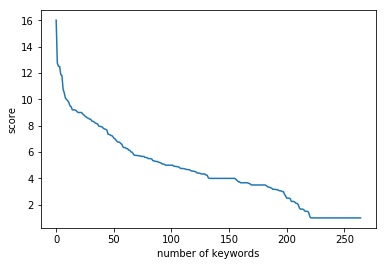

In [9]:
plt.plot([k[1] for k in candidate_keywords])
plt.xlabel("number of keywords")
plt.ylabel("score")

### Apply code to all files in corpus

We will rerun the above code for all the files in our corpus and generate a file of raw keywords generated by RAKE.

In [10]:
if not os.path.exists(RAKE_KEYWORDS):
    frak = open(RAKE_KEYWORDS, "w")
    i = 0
    for filename in os.listdir(TEXTFILES_DIR):
        if i % 100 == 0:
            print("{:d} files processed".format(i))
        doc_id = int(filename.split(".")[0])
        textfile_name = os.path.join(TEXTFILES_DIR, filename)
        sentence_list = split_sentences(textfile_name)
        phrase_list = generate_phrases(sentence_list, stop_word_pattern)
        word_scores = calculate_word_scores(phrase_list)
        candidate_keywords_scored = generate_candidate_keyword_scores(phrase_list, word_scores)
        candidate_keywords = filter_sort_top_keywords(candidate_keywords_scored, 
                                                  score_cutoff=5.0)
        for keyword, score in candidate_keywords:
            frak.write("{:d}\t{:s}\t{:.3f}\n".format(doc_id, keyword, score))
        i += 1

    print("{:d} files processed, COMPLETE".format(i))
    frak.close()

### Load into DB for grouping

In [11]:
def table_exists(conn, table_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='table' and name = ?", 
                [table_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0


def create_rake_table(conn):
    if not table_exists(conn, "rake"):
        cur = conn.cursor()
        create_table = """create table rake(
            id INTEGER NOT NULL,
            keyword VARCHAR(50) NOT NULL, 
            doc_id INTEGER NOT NULL)
        """
        cur.execute(create_table)
        cur.close()


def index_exists(conn, index_name):
    cur = conn.cursor()
    cur.execute("select name from sqlite_master where type='index' and name = ?", 
                [index_name])
    rows = cur.fetchall()
    cur.close()
    return len(rows) > 0


def create_rake_indexes(conn):
    cur = conn.cursor()
    index_names = ["ix_rake", "ax1_rake", "ax2_rake"]
    create_indexes = [
        "create unique index ix_rake on rake(id)",
        "create index ax1_rake on rake(keyword)",
        "create index ax2_rake on rake(doc_id)"
    ]
    for index_name, create_index in zip(index_names, create_indexes):
        if not index_exists(conn, index_name):
            cur.execute(create_index)
    cur.close()


def insert_keyword(conn, id, keyword, doc_id, commit=False):
    cur = conn.cursor()
    cur.execute("insert into rake(id, keyword, doc_id) values (?, ?, ?)", 
                [id, keyword, doc_id])
    if commit:
        conn.commit()
    cur.close()

        
def count_words_in_table(conn):
    cur = conn.cursor()
    cur.execute("select count(*) as cnt from rake")
    rows = cur.fetchone()
    return int(rows[0])
    cur.close()


conn = sqlite3.connect(WORDCOUNTS_DB)
create_rake_table(conn)

In [12]:
num_keywords = count_words_in_table(conn)
keyword_id = 0
should_commit = False
if num_keywords == 0:
    frake = open(RAKE_KEYWORDS, "r")
    for line in frake:
        if keyword_id % 100 == 0:
            print("{:d} records inserted".format(keyword_id))
            should_commit = True
        doc_id, keyword, _ = line.strip().split("\t")
        if len(keyword.strip()) == 0:
            continue
        insert_keyword(conn, keyword_id, keyword, doc_id, should_commit)
        should_commit = False
        keyword_id += 1
    frake.close()
    print("{:d} records inserted, COMPLETE".format(keyword_id))
    conn.commit()

In [13]:
create_rake_indexes(conn)

In [14]:
cur = conn.cursor()
cur.execute("""
    select keyword, count(*) as freq
    from rake
    group by keyword
    having freq > 5
    order by freq desc
""")
candidate_keywords = []
rows = cur.fetchall()
i = 0
for keyword, freq in rows:
    words = keyword.split(" ")
    num_words = len(words)
    if num_words < 2:
        # for search, we don't care about unigrams
        continue
    words_filtered = [w for w in words if len(w.strip()) > 0]
    if num_words < 2:
        continue
    candidate_keywords.append((keyword, freq))
    if i <= 10:
        print(keyword, freq)
    i += 1

machine learning 1286
neural networks 1216
figure shows 969
training data 961
training set 715
neural network 690
would like 647
objective function 555
learning algorithm 553
lower bound 532
loss function 523


### Plot frequency distribution to find cutoff

Text(0,0.5,'frequency')

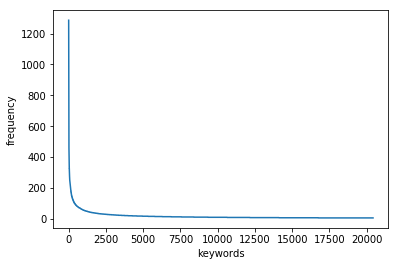

In [15]:
plt.plot([ck[1] for ck in candidate_keywords])
plt.xlabel("keywords")
plt.ylabel("frequency")

### Write out top 2500 keywords

In [16]:
fcrk = open(CANDIDATE_RAKE, "w")
for keyword, freq in candidate_keywords[0:2500]:
    fcrk.write("{:s}\t{:d}\n".format(keyword, freq))
fcrk.close()